# Import and settings

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import anndata
import scanpy as sc
import scanpy_scripts as ss

np.set_printoptions(linewidth=180)
sc.settings.verbosity = 1
expr_cmap = ss.lib.expression_colormap()

# Define functions

In [2]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0))
    return (cumsum[N:] - cumsum[:-N]) / float(N)

In [3]:
def find_threshold(y, smooth_window=50, max_n=10000, plot=None):
    """Find local minimum of the 1st numeric derivative of knee point in the specified range"""
    sc.logging.info('started')
    i = smooth_window // 2
    y = y[np.argsort(-y)]
    y = np.log10(y[y>0])
    x = 1 + np.arange(y.shape[0])
    x = np.log10(x)
    dy = np.diff(y)/np.diff(x)
    dy = running_mean(dy, smooth_window)
    k = np.argmin(dy[0:max_n])
    threshold = y[k+i]
    if plot and (plot.endswith('png') or plot.endswith('pdf')):
        import matplotlib.pyplot as plt
        plt.switch_backend('Agg')
        plt.plot(x, y)
        plt.hlines(threshold, xmin=min(x), xmax=max(x), linewidth=1)
        plt.savefig(plot)
    sc.logging.info('done')
    return 10**threshold

In [4]:
def simple_filter(raw_ad, max_n=6000):
    nUMI = raw_ad.X.sum(axis=1).A1
    cutoff = find_threshold(nUMI, max_n=max_n)
    sc.logging.warn(f'cutoff = {cutoff}')
    return raw_ad[nUMI>=cutoff, :].copy()

# Processing

### Prepare filtered and merged dataset

In [5]:
sample_info = pd.read_csv('martin19/sample_info.txt', sep='\t')

In [6]:
sample_info['sample_id'] = sample_info['sample_id'].astype(str)

In [7]:
sample_info['file_id'] = sample_info.gsm_id + '_' + sample_info.sample_id.astype(str)

In [8]:
sample_info.head()

,gsm_id,tissue,lesion,sample_id,file_id
0,GSM3972009,Ileal,Involved,69,GSM3972009_69
1,GSM3972010,Ileal,Uninvolved,68,GSM3972010_68
2,GSM3972011,Ileal,Involved,122,GSM3972011_122
3,GSM3972012,Ileal,Uninvolved,123,GSM3972012_123
4,GSM3972013,Ileal,Involved,128,GSM3972013_128


In [9]:
raw_ads0 = [sc.read(f'martin19/{s}.h5ad') for s in sample_info.file_id]

In [24]:
raw_ads1 = [simple_filter(rad0, 5000) for rad0 in raw_ads0]

In [50]:
np.array([rad1.n_obs for rad1 in raw_ads1])

array([4236, 5019, 2355, 4826, 4046, 3686, 4791, 4983, 4747, 4734, 4211, 1311, 4927, 4213, 5025, 4939, 4831, 1386, 4909, 4803, 4388, 4948])

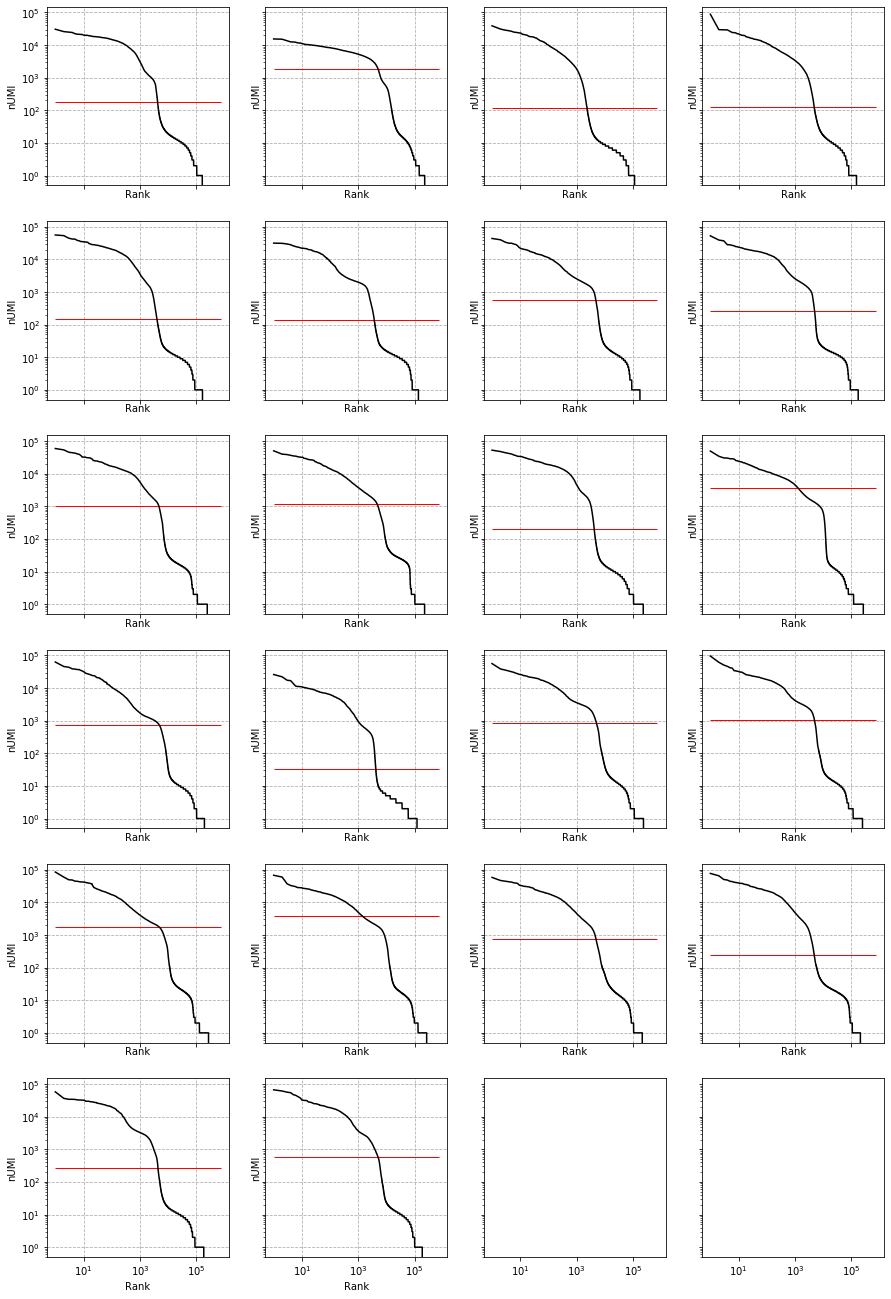

In [25]:
ss.lib.set_figsize((15, 23))
fig, ax = plt.subplots(nrows=6, ncols=4, sharex=True, sharey=True)
for i in range(len(raw_ads0)):
    a = i // 4
    b = i % 4
    ss.lib.plot_metric_by_rank(raw_ads0[i], swap_axis=True, hpos=raw_ads1[i].X.sum(axis=1).min(), ax=ax[a, b])
    ax[a,b].set_ylim(0.5, 1.5e5)

In [52]:
raw_ad1 = anndata.AnnData.concatenate(*raw_ads1, batch_categories=sample_info.sample_id.astype(str).to_list())

In [53]:
gene_ids = raw_ad1.var['gene_ids-69'].copy()
for k in list(raw_ad1.var.columns):
    del raw_ad1.var[k]
raw_ad1.var['gene_ids'] = gene_ids

In [68]:
raw_ad1.obs = raw_ad1.obs.reset_index().merge(
    sample_info[['sample_id', 'lesion']], how='left', left_on='batch', right_on='sample_id').set_index('index')

In [73]:
raw_ad1.obs.head()

,batch,n_counts,sample_id,lesion
index,,,,
AAACATACAACCTG-1-69,69,549.0,69,Involved
AAACATACACACCA-1-69,69,1233.0,69,Involved
AAACATTGGTGTCA-1-69,69,4144.0,69,Involved
AAACGCACTCGCTC-1-69,69,190.0,69,Involved
AAACGCACTTAGGC-1-69,69,5807.0,69,Involved


In [69]:
raw_ads = ss.lib.split_by_group(raw_ad1, 'lesion')

In [71]:
for name, raw_ad in raw_ads.items():
    raw_ad.write(f'martin19/martin19-{name.lower()}.h5ad', compression='lzf')

... storing 'batch' as categorical
... storing 'sample_id' as categorical
... storing 'lesion' as categorical
... storing 'batch' as categorical
... storing 'sample_id' as categorical
... storing 'lesion' as categorical


### Annotate broad cell type

In [5]:
raw_ad  = sc.read('martin19/martin19-uninvolved.h5ad')

In [6]:
raw_ad

AnnData object with n_obs × n_vars = 51347 × 33694 
    obs: 'batch', 'n_counts', 'sample_id', 'lesion'
    var: 'gene_ids'

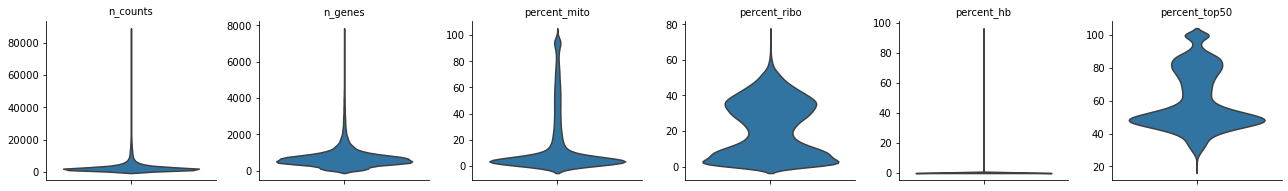

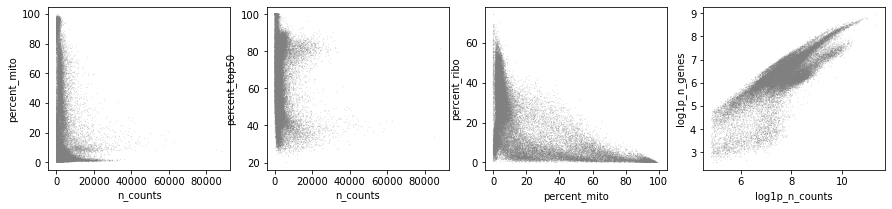

In [7]:
ss.lib.calculate_qc(raw_ad)
ss.lib.plot_qc(raw_ad)

In [9]:
ad = ss.lib.simple_default_pipeline(raw_ad, batch='sample_id', filter_kw={'metrics': ['n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'percent_hb']})

/home/ubuntu/miniconda/envs/scrna/lib/python3.6/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../miniconda/envs/scrna/lib/python3.6/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  self.func_ir.loc))
/home/ubuntu/miniconda/envs/scrna/lib/python3.6/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../miniconda/envs/scrna/lib/

In [10]:
ss.lib.leiden(ad, use_graph='neighbors_hm', resolution=[2.0], key_added='hm')

['leiden_hm_r2_0']

In [11]:
# According to https://www.cell.com/cell/fulltext/S0092-8674(19)30896-7, fig1C
markers = '''
CD3D CD2 CD7
TNFRSF17 MZB1
BANK1 CD79B CD22 MS4A1
HLA-DRB1 HLA-DQA1 LYZ
IL3RA IRF7 GZMB LILRA4 CLEC4C
TPSAB1 CMA1 KIT
PLVAP VWF
LYVE1 CCL21
COL3A1 COL1A1 ACTA2
GPM6B S100B
'''.split()

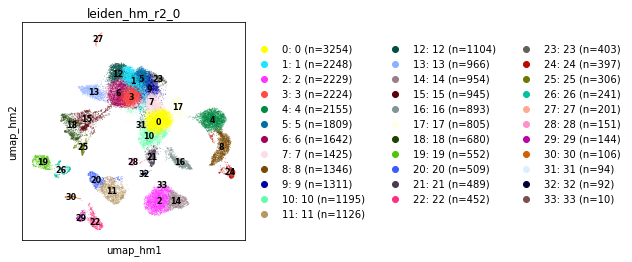

In [12]:
ss.lib.plot_embedding(ad, basis='umap_hm', groupby='leiden_hm_r2_0', figsize=(4,4), alpha=0.5)

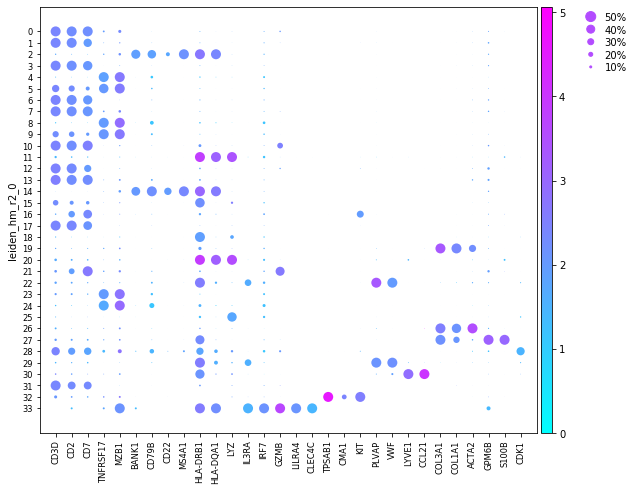

In [13]:
_ = sc.pl.dotplot(ad, markers + ['CDK1'], groupby='leiden_hm_r2_0', figsize=(10, 8), dot_max=0.5, color_map='cool', mean_only_expressed=True)

In [14]:
# According to https://www.cell.com/cell/fulltext/S0092-8674(19)30896-7 fig1C, fig2
broad_celltype_mapping = {
    'T cells': ['0', '1', '3', '6', '7', '10', '12', '13', '17', '28', '31'],
    'ILC': ['16', '21'],
    'Plasma cells': ['4', '8', '24'],
    'B cells': ['2', '14'],
    'MNP': ['11', '20'],
    'Mast cells': ['32'],
    'Stroma': ['15', '18', '19', '22', '25', '26', '27', '29', '30'],
    'Cycling': ['28'],
    'Doublets': ['5', '9', '23', '33']
}

In [15]:
ad.obs['BroadCellType'] = ss.lib.regroup(ad, 'leiden_hm_r2_0', broad_celltype_mapping)

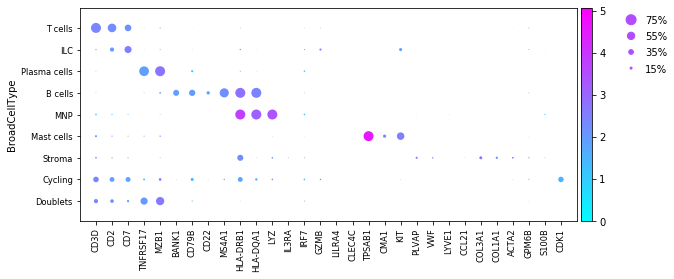

In [16]:
_ = sc.pl.dotplot(ad, markers + ['CDK1'], groupby='BroadCellType', figsize=(10, 4), dot_max=0.75, color_map='cool', mean_only_expressed=True)

In [17]:
ad_smp = ss.lib.subsample(ad, fraction=0.1, groupby='BroadCellType', min_n=10, max_n=200)

In [18]:
ad_smp

View of AnnData object with n_obs × n_vars = 1329 × 22340 
    obs: 'batch', 'n_counts', 'sample_id', 'lesion', 'log1p_n_counts', 'n_genes', 'log1p_n_genes', 'percent_mito', 'percent_ribo', 'percent_hb', 'percent_top50', 'leiden_hm_r0_1', 'leiden_hm_r0_3', 'leiden_hm_r0_5', 'leiden_hm_r0_7', 'leiden_hm_r0_9', 'leiden_hm_r2_0', 'BroadCellType'
    var: 'gene_ids', 'mito', 'ribo', 'hb', 'n_counts', 'n_cells', 'n_genes', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'pca', 'neighbors_hm', 'neighbors', 'leiden', 'leiden_hm_r2_0_colors'
    obsm: 'X_pca', 'X_pca_hm', 'X_umap_hm'
    varm: 'PCs'

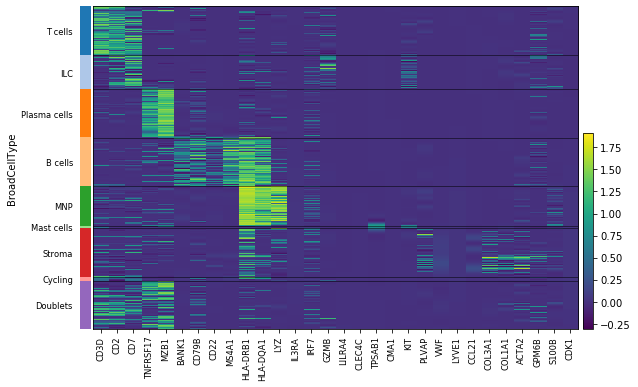

In [19]:
_ = sc.pl.heatmap(ad_smp, markers + ['CDK1'], groupby='BroadCellType', log=True)

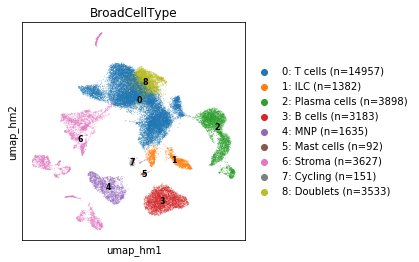

In [20]:
ss.lib.plot_embedding(ad, basis='umap_hm', groupby='BroadCellType', figsize=(4,4), alpha=0.5, legend_loc='on data')

### Zoom in to stroma

In [21]:
# According to https://www.cell.com/cell/fulltext/S0092-8674(19)30896-7, fig2g
# and https://rupress.org/jem/article-abstract/217/2/e20191130/132578/Single-cell-transcriptome-analysis-reveals, fig1D
stroma_markers = '''
VWF RAMP3 NPDC1 JAM2 PLVAP NOTCH4
HSPG2 ESAM CYYR1 CD93 ICAM2 S1PR1
RAMP2 CD36 CA4 TMEM88 FLT1 SELP
SELE ACKR1 DUSP23 CXorf36 KDR
PROX1 MMRN1 RELN ANGPT2 CCL21 LYVE1
TFF3 RGS5 NDUFA4L2 ACTG2 MYH11
CXCL14 ADH1B CTSK MMP2 LUM PTGDS
CCL2 TCF21 ADAMDEC1 CCL13 CCL8
ADAM28 HAPLN1 ABCA8 CFD THY1
CHI3L1 BGN PDPN CXCL2 CXCL8
TNFRSF12A SOX2 CADM1 SORCS1 LGI4
ALDH1A1 CAB39L NTM ANK3 PRIMA1
HAND2 GPM6B CRYAB SLC22A17 ERBB3
CDH19 TMEM71 NRXN1 S100B MPZ
MYOT SCN7A PLP1 CNP SPP1 AP1S2 CLU
ALDOB ADIRF IL32 SEPP1 APOC3
SPINK4 FCGBP CLCA1 ITLN1
SPIB CA7 BEST4 LYZ
NEUROD1 CHGA FEV CHGB CRYBA2
OLFM4 ADH1C PIGR DMBT1
HMGB2 STMN1 H2AFZ TUBA1B
RGMB ASCL2 SOX4 SLC12A2
'''.split()

In [22]:
stroma_ad = ad[ad.obs.BroadCellType == 'Stroma', :].copy()

In [23]:
stroma_ad

AnnData object with n_obs × n_vars = 3627 × 22340 
    obs: 'batch', 'n_counts', 'sample_id', 'lesion', 'log1p_n_counts', 'n_genes', 'log1p_n_genes', 'percent_mito', 'percent_ribo', 'percent_hb', 'percent_top50', 'leiden_hm_r0_1', 'leiden_hm_r0_3', 'leiden_hm_r0_5', 'leiden_hm_r0_7', 'leiden_hm_r0_9', 'leiden_hm_r2_0', 'BroadCellType'
    var: 'gene_ids', 'mito', 'ribo', 'hb', 'n_counts', 'n_cells', 'n_genes', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'pca', 'neighbors_hm', 'neighbors', 'leiden', 'leiden_hm_r2_0_colors', 'BroadCellType_colors'
    obsm: 'X_pca', 'X_pca_hm', 'X_umap_hm'
    varm: 'PCs'

In [24]:
ss.lib.simple_default_pipeline(stroma_ad, post_norm_only=True, batch='sample_id')

AnnData object with n_obs × n_vars = 3627 × 22340 
    obs: 'batch', 'n_counts', 'sample_id', 'lesion', 'log1p_n_counts', 'n_genes', 'log1p_n_genes', 'percent_mito', 'percent_ribo', 'percent_hb', 'percent_top50', 'leiden_hm_r0_1', 'leiden_hm_r0_3', 'leiden_hm_r0_5', 'leiden_hm_r0_7', 'leiden_hm_r0_9', 'leiden_hm_r2_0', 'BroadCellType'
    var: 'gene_ids', 'mito', 'ribo', 'hb', 'n_counts', 'n_cells', 'n_genes', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'pca', 'neighbors_hm', 'leiden', 'leiden_hm_r2_0_colors', 'BroadCellType_colors', 'neighbors'
    obsm: 'X_pca', 'X_pca_hm', 'X_umap_hm'
    varm: 'PCs'

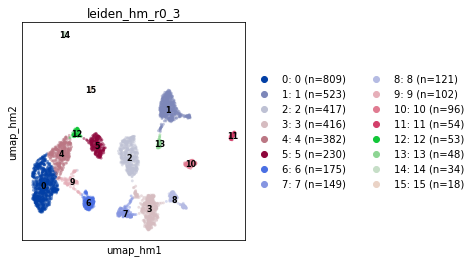

In [25]:
ss.lib.plot_embedding(stroma_ad, basis='umap_hm', groupby='leiden_hm_r0_3', figsize=(4,4), alpha=0.5)

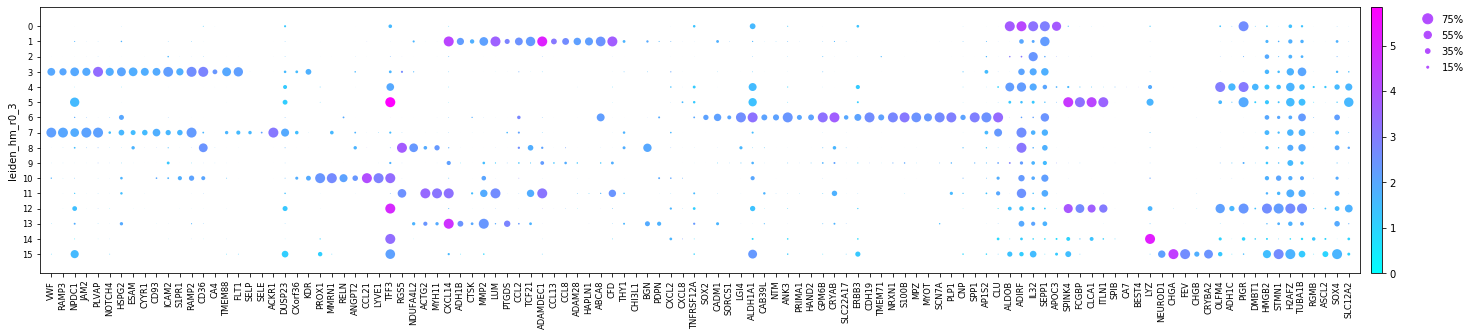

In [26]:
_ = sc.pl.dotplot(stroma_ad, stroma_markers, groupby='leiden_hm_r0_3', figsize=(25, 5), dot_max=0.75, color_map='cool', mean_only_expressed=True)

In [27]:
# According to https://www.cell.com/cell/fulltext/S0092-8674(19)30896-7 fig1C, fig2
stroma_celltype_mapping = {
    'CD36+ endothelium': ['3'],
    'ACKR1+ endothelium': ['7'],
    'Lymphatics': ['10'],
    'Pericytes': ['8'],
    'SM': ['11'],
    'Fibs': ['1', '13'],
    'Glial cells': ['6'],
    'Enterocytes': ['0'],
    'Goblets': ['5'],
    'Paneth cells': ['14'],
    'Enteroendocrines': ['15'],
    'Progenitors': ['4'],
    'TA': ['12'],
    'Doublets': ['2', '9'],
}

In [28]:
stroma_ad.obs['StromaCellType'] = ss.lib.regroup(stroma_ad, 'leiden_hm_r0_3', stroma_celltype_mapping)

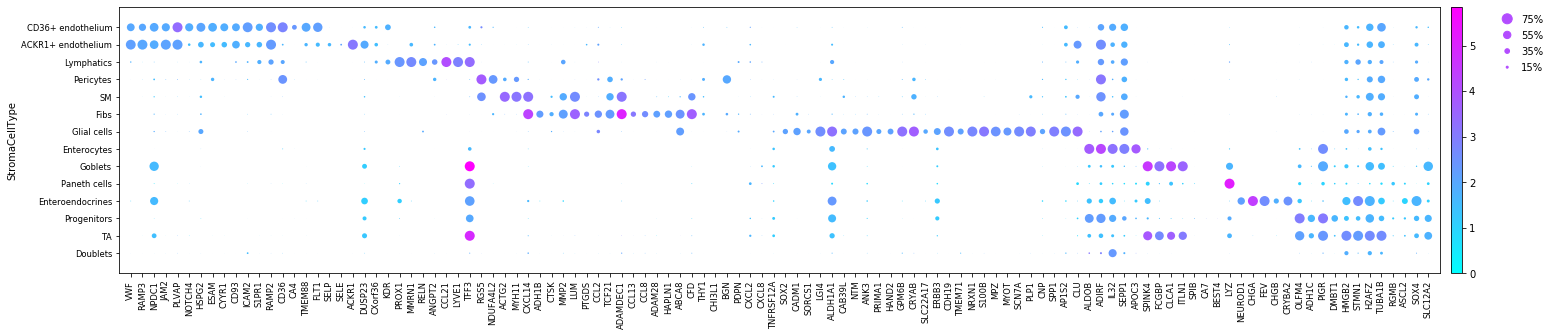

In [29]:
_ = sc.pl.dotplot(stroma_ad, stroma_markers, groupby='StromaCellType', figsize=(25, 5), dot_max=0.75, color_map='cool', mean_only_expressed=True)

### Merge stroma annotation back

In [30]:
ad.obs = ad.obs.merge(stroma_ad.obs[['StromaCellType']], how='left', left_index=True, right_index=True)
ad.obs['CellType'] = ad.obs['BroadCellType'].astype(str)
ad.obs.loc[ad.obs.StromaCellType.astype(str) != 'nan', 'CellType'] = ad.obs.loc[ad.obs.StromaCellType.astype(str) != 'nan', 'StromaCellType'].astype(str)
ad.obs['CellType'] = ad.obs['CellType'].astype('category')

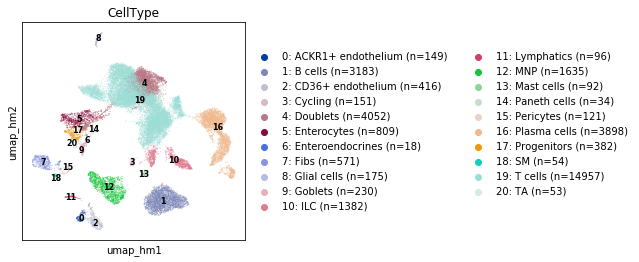

In [31]:
ss.lib.plot_embedding(ad, basis='umap_hm', groupby='CellType', figsize=(4,4), alpha=0.5)

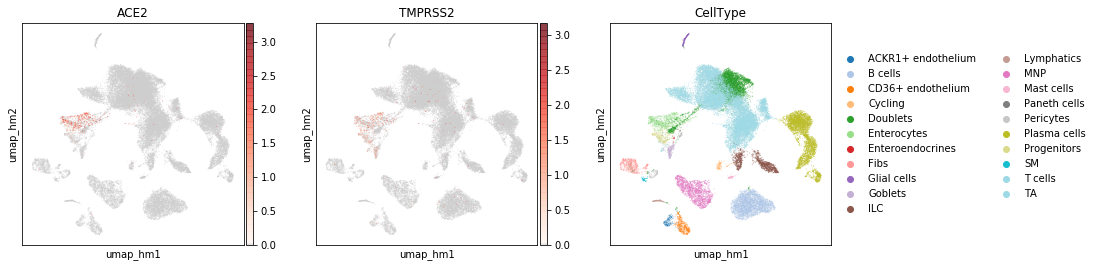

In [41]:
ss.lib.set_figsize((4, 4))
ss.lib.plot_scatter(ad, basis='umap_hm', color=['ACE2', 'TMPRSS2', 'CellType'], alpha=0.5, color_map=expr_cmap, palette='tab20')

In [32]:
celltype_mapping1 = {
    'Immune cells': ['T cells', 'ILC', 'Plasma cells', 'B cells', 'MNP', 'Mast cells'],
    'Endothelium': ['CD36+ endothelium', 'ACKR1+ endothelium', 'Lymphatics'],
}

In [33]:
ad.obs['CellType1'] = ss.lib.regroup(ad, groupby='CellType', regroups=celltype_mapping1)

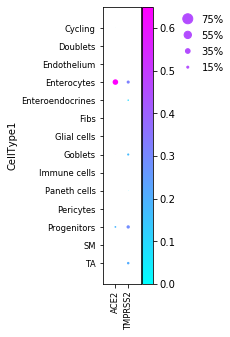

GridSpec(2, 5, height_ratios=[0, 10.5], width_ratios=[0.7, 0, 0.2, 0.5, 0.25])

In [35]:
sc.pl.dotplot(ad, ['ACE2', 'TMPRSS2'], groupby='CellType1', dot_max=0.75, color_map='cool')